In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np


In [2]:
# ======= Define model classes again (same as training) =======
import torch.nn as nn

class ImageClassificationBase(nn.Module):
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = (torch.argmax(out, 1) == labels).float().mean()
        return {"val_loss": loss.item(), "val_accuracy": acc.item()}

def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [3]:
# ======= Load model =======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 38
model = ResNet9(in_channels=3, num_classes=num_classes)
model.load_state_dict(torch.load("plant-disease-model.pth", map_location=device))
model.to(device)
model.eval()

C:\Users\JASH DESAI\AppData\Local\Temp\ipykernel_14068\490079294.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("plant-disease-model.pt

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [6]:
# ======= Load validation data =======
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

val_data = datasets.ImageFolder(r"D:\Model\Kaggle\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid", transform=transform)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [10]:
# ======= Evaluate model =======
val_losses = []
val_accuracies = []
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        acc = (outputs.argmax(1) == labels).float().mean()

        val_losses.append(loss.item())
        val_accuracies.append(acc.item())

        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


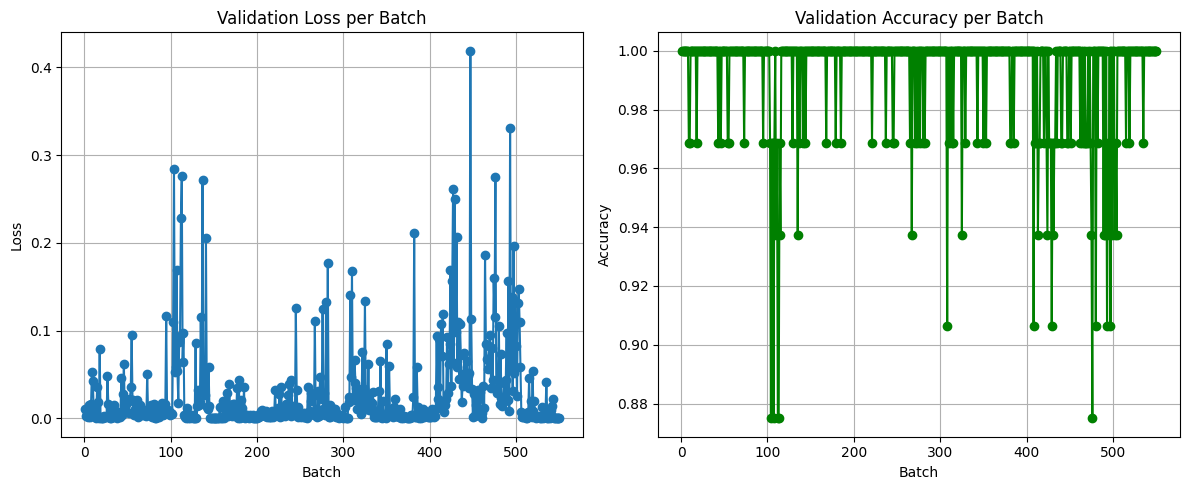

In [11]:
# ======= Plot Loss and Accuracy =======
epochs = list(range(1, len(val_losses) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, marker='o')
plt.title("Validation Loss per Batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='o', color='green')
plt.title("Validation Accuracy per Batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


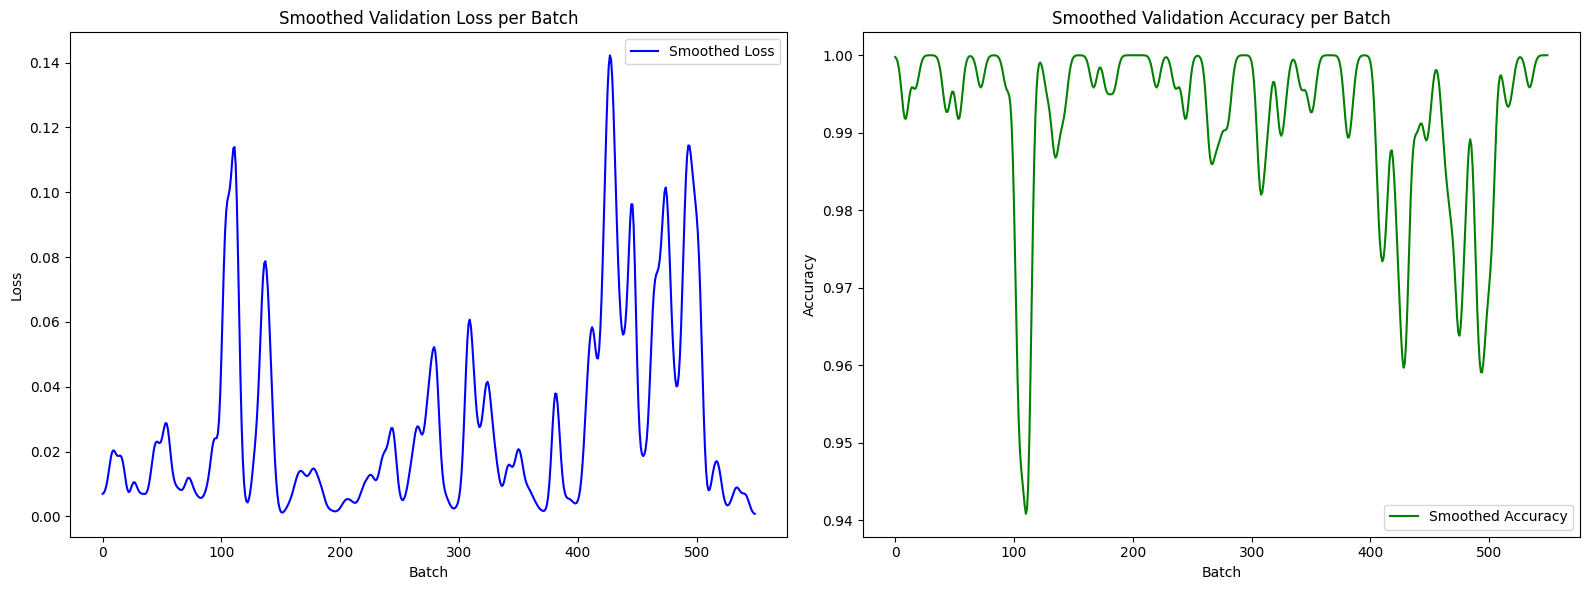

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Assuming val_losses and val_accuracies are your lists of per-batch values
# Smooth using Gaussian filter
smoothed_losses = gaussian_filter1d(val_losses, sigma=3)
smoothed_accuracies = gaussian_filter1d(val_accuracies, sigma=3)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Left: Smoothed Loss
axs[0].plot(smoothed_losses, color='blue', label="Smoothed Loss")
axs[0].set_title("Smoothed Validation Loss per Batch")
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Right: Smoothed Accuracy
axs[1].plot(smoothed_accuracies, color='green', label="Smoothed Accuracy")
axs[1].set_title("Smoothed Validation Accuracy per Batch")
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()


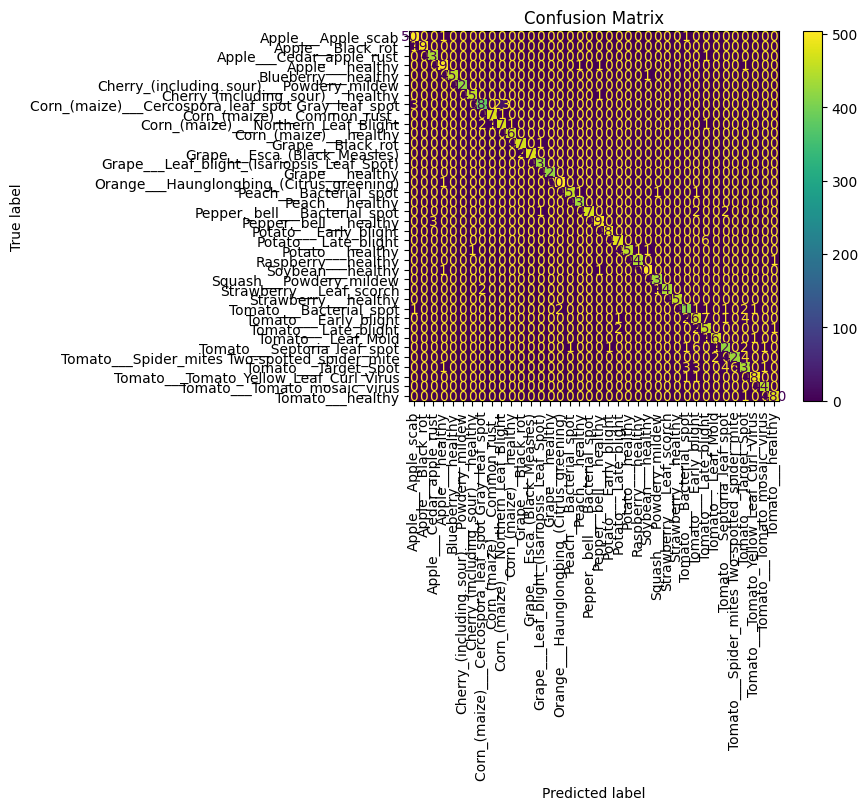

In [18]:
# ======= Confusion Matrix =======
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.classes)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

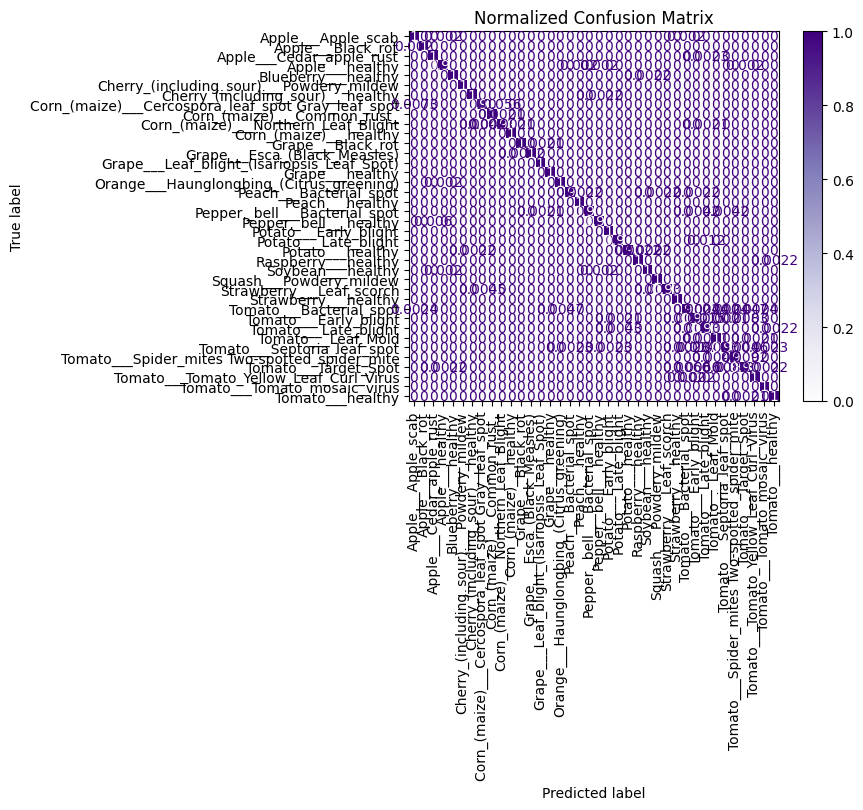

In [21]:
class_names = val_data.classes

# ======= Normalized Confusion Matrix =======
class_names = val_data.classes  # Fix: Get class names from the dataset
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp_norm.plot(xticks_rotation=90, cmap="Purples")
plt.title("Normalized Confusion Matrix")
plt.show()


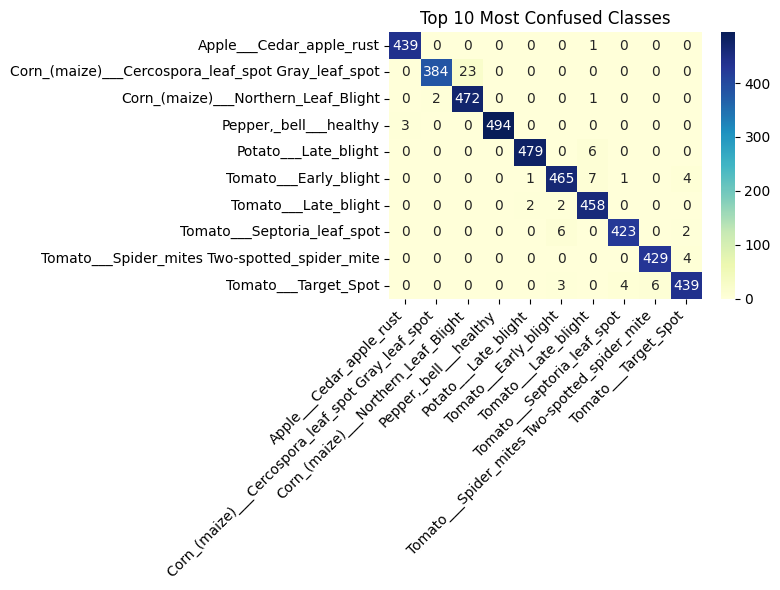


📊 Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      1.00      0.99       504
                                 Apple___Black_rot       1.00      1.00      1.00       497
                          Apple___Cedar_apple_rust       0.99      1.00      1.00       440
                                   Apple___healthy       0.99      0.99      0.99       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.99      0.94      0.96       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight  

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# ======= Top-N Confused Classes Heatmap =======
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)
top_n = 10
confused_pairs = np.unravel_index(np.argsort(cm_no_diag.ravel())[-top_n:], cm.shape)
confused_labels = np.unique(np.concatenate((confused_pairs[0], confused_pairs[1])))

sub_cm = cm[np.ix_(confused_labels, confused_labels)]

plt.figure(figsize=(8, 6))
sns.heatmap(
    sub_cm,
    annot=True,
    fmt='d',
    xticklabels=[class_names[i] for i in confused_labels],
    yticklabels=[class_names[i] for i in confused_labels],
    cmap="YlGnBu"
)
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Most Confused Classes")
plt.tight_layout()
plt.show()

# ======= Classification Report =======
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\n📊 Classification Report:\n")
print(report)

In [24]:
# ======= Print final stats =======
print(f"\n✅ Average Validation Accuracy: {np.mean(val_accuracies)*100:.2f}%")
print(f"❌ Average Validation Loss: {np.mean(val_losses):.4f}")


✅ Average Validation Accuracy: 99.19%
❌ Average Validation Loss: 0.0284
